In [53]:
import math

# visualisation
import matplotlib.pyplot as plt
import matplotlib.lines as lines
# visualisation

def Sum_points(P1, P2):
    x1, y1 = P1
    x2, y2 = P2
    return x1+x2, y1+y2

def Multiply_point(multiplier, P):
    x, y = P
    return float(x)*float(multiplier), float(y)*float(multiplier)

def Check_if_object_is_polygon(Cartesian_coords_list):
    if Cartesian_coords_list[0] == Cartesian_coords_list[len(Cartesian_coords_list)-1]:
        return True
    else:
        return False

class Object():

    def __init__(self, Cartesian_coords_list):
        self.Cartesian_coords_list = Cartesian_coords_list

    def Find_Q_point_position(self, P1, P2):
        Summand1 = Multiply_point(float(3)/float(4), P1)
        Summand2 = Multiply_point(float(1)/float(4), P2)
        Q = Sum_points(Summand1, Summand2) 
        return Q

    def Find_R_point_position(self, P1, P2):
        Summand1 = Multiply_point(float(1)/float(4), P1)
        Summand2 = Multiply_point(float(3)/float(4), P2)        
        R = Sum_points(Summand1, Summand2)
        return R

    def Smooth_by_Chaikin(self, number_of_refinements):
        refinement = 1
        copy_first_coord = Check_if_object_is_polygon(self.Cartesian_coords_list)
        while refinement <= number_of_refinements:
            self.New_cartesian_coords_list = []

            for num, tuple in enumerate(self.Cartesian_coords_list):
                if num+1 == len(self.Cartesian_coords_list):
                    pass
                else:
                    P1, P2 = (tuple, self.Cartesian_coords_list[num+1])
                    Q = obj.Find_Q_point_position(P1, P2)
                    R = obj.Find_R_point_position(P1, P2)
                    self.New_cartesian_coords_list.append(Q)
                    self.New_cartesian_coords_list.append(R)

            if copy_first_coord:
                self.New_cartesian_coords_list.append(self.New_cartesian_coords_list[0])

            self.Cartesian_coords_list = self.New_cartesian_coords_list
            refinement += 1
        return self.Cartesian_coords_list


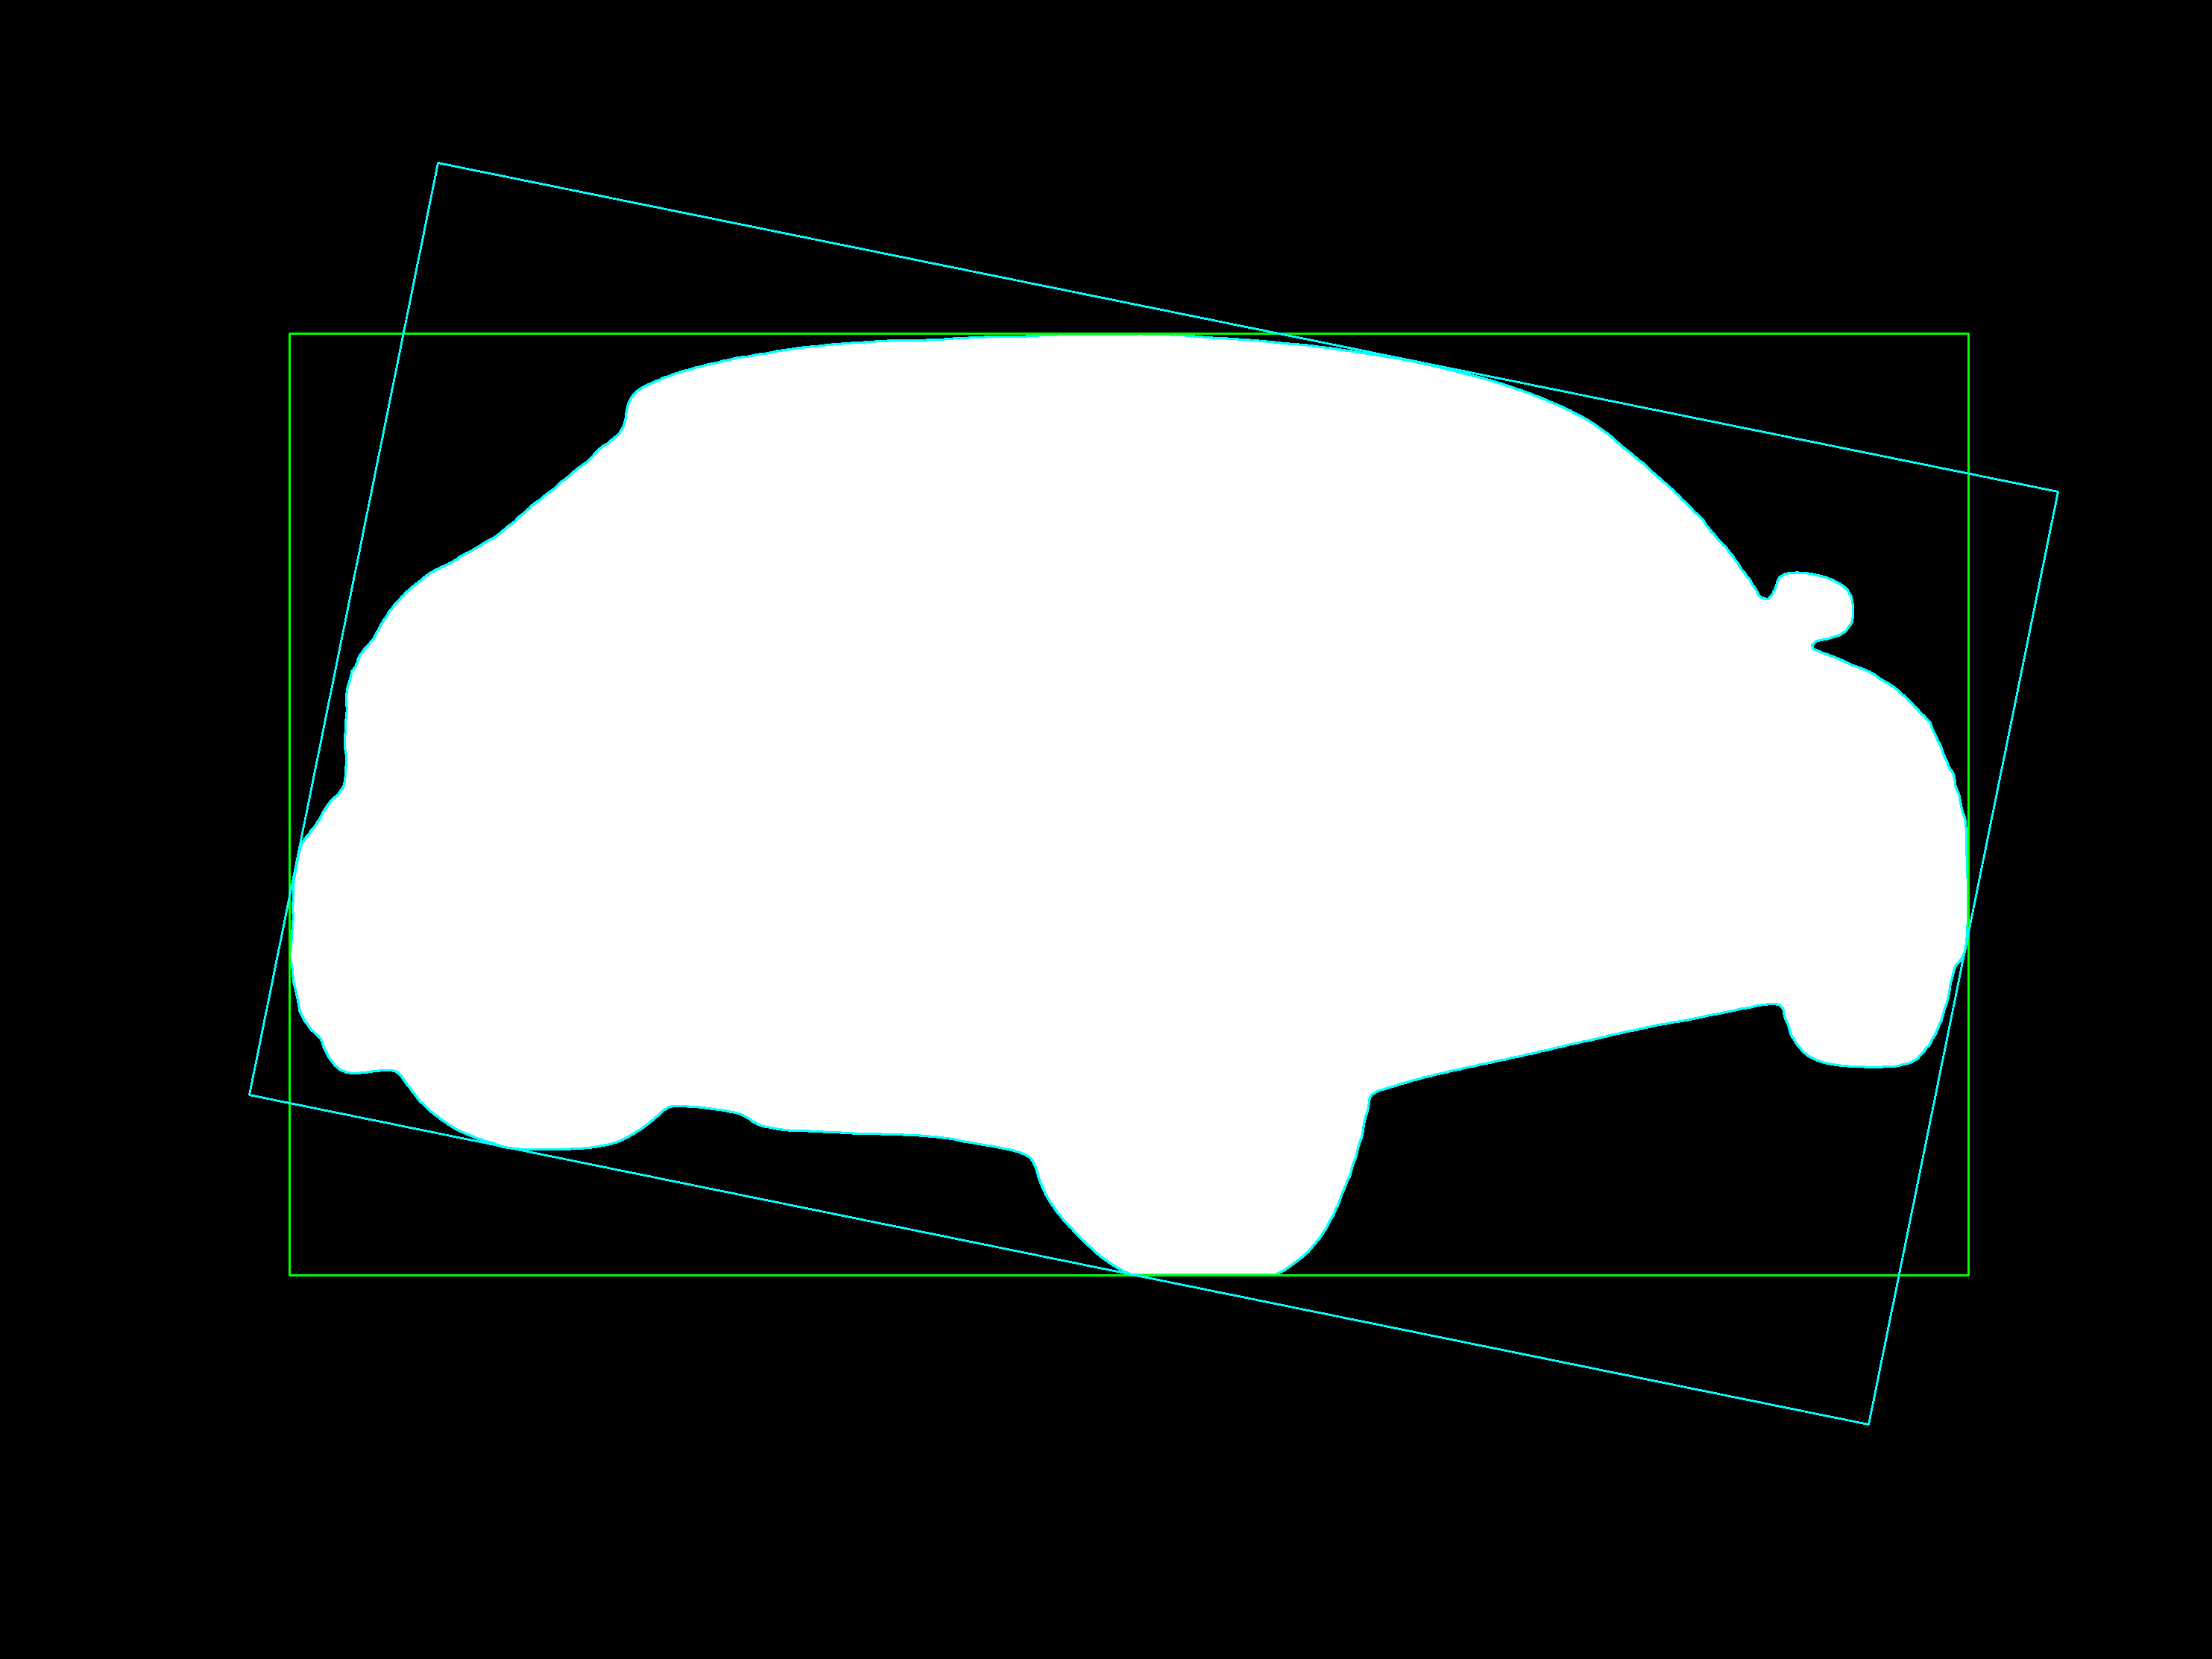

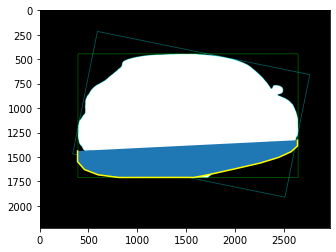

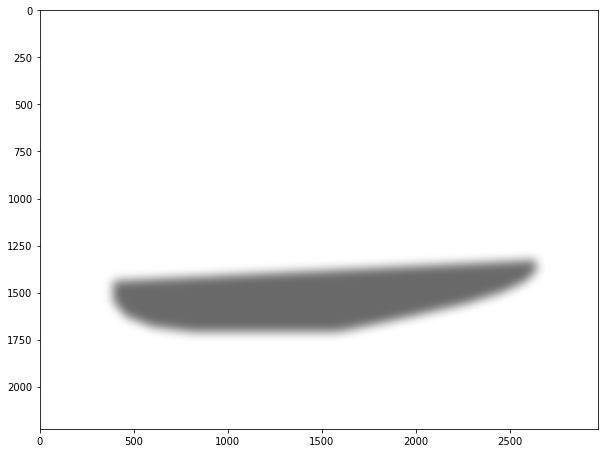

In [65]:
from PIL import Image
import cv2
import numpy as np
from shapely.geometry import Polygon

img_path = 'rearright1_mask.png'
dir_path = '/home/ubuntu/Users/maixueqiao/image-processing/'

def get_pts(img_path: str, dir_path: str):
    
    # read the input mask image
    img = cv2.imread(dir_path+img_path)
    # img = cv2.bitwise_not(img)
    # convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # apply thresholding on the gray image to create a binary image
    ret,thresh = cv2.threshold(gray,127,255,0)

    # find the contours
    contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    # take the first contour
    cnt = max(contours, key = cv2.contourArea)

    # compute the bounding rectangle of the contour
    x,y,w,h = cv2.boundingRect(cnt)

    # draw contour
    img = cv2.drawContours(img,[cnt],0,(0,255,255),2)

    # draw the bounding rectangle
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    
    # bbox 
    bbox = [[x,y+h],[x,y],[x+w, y], [x+w,y+h]]
    
    # compute rotated rectangle (minimum area)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    min_bbox = [x.tolist() for l in [box] for x in l]
    img = cv2.drawContours(img,[box],0,(0,255,255),2)
    
    # The extreme points
    l_m = list(cnt[cnt[:, :, 0].argmin()][0])
    r_m = list(cnt[cnt[:, :, 0].argmax()][0])
    t_m = list(cnt[cnt[:, :, 1].argmin()][0])
    b_m = list(cnt[cnt[:, :, 1].argmax()][0])
    pst = [l_m, r_m, t_m, b_m]
    xcor = [p[0] for p in pst]
    ycor = [p[1] for p in pst]
    
    display(Image.fromarray(img))
    
    return img, bbox, min_bbox, pst

img, bbox, min_bbox, pst = get_pts(img_path,dir_path)

# unpack points
l_m, r_m, t_m, b_m = pst
bottomleft, topleft, topright, bottomright = bbox[0], bbox[1], bbox[2], bbox[3]

def get_linear(mbottomleft, mtopleft, mtopright, mbottomright, bottom_horizontal, right_vertical, left_vertical):
        bottom_slope =  (mbottomright[1]-mbottomleft[1])/(mbottomright[0]-mbottomleft[0])
        bottom_slope_c = mbottomright[1]-(bottom_slope*mbottomright[0])
        right_yintersect = bottom_slope*right_vertical+bottom_slope_c
        
        left_slope = (mtopleft[1]-mbottomleft[1])/(mtopleft[0]-mbottomleft[0])
        left_slope_c = mbottomleft[1]-(left_slope*mbottomleft[0])
        left_xinterset = (bottom_horizontal-left_slope_c) /left_slope
        
        right_slope = (mtopright[1]-mbottomright[1])/(mtopright[0]-mbottomright[0])
        right_slope_c = mbottomright[1]-(right_slope*mbottomright[0])
        right_xinterset = (bottom_horizontal-right_slope_c) /right_slope
        
        return bottom_slope, bottom_slope_c, left_slope, left_slope_c, right_slope, right_slope_c


def get_polygon(min_bbox, bbox, pst, angle, bottom_horizontal, right_vertical, left_vertical):
    # check if min_rotated_rec overlaps with bbox 
    if any(ele in bbox for ele in min_bbox):
        polygon_pts = [l_m, bottomleft, b_m, [b_m[0]+150,b_m[1]],[r_m[0],(r_m[1]+b_m[1])/2], r_m]

    else:
        if angle == 'front-left':
            mtopleft, mtopright, mbottomright, mbottomleft = min_bbox[0], min_bbox[1], min_bbox[2], min_bbox[3]
            bottom_slope, bottom_slope_c, left_slope, left_slope_c, right_slope, right_slope_c = get_linear(mbottomleft, mtopleft, mtopright, mbottomright, bottomright[1], bottomright[0], bottomleft[0])
            left_xinterset = (bottom_horizontal-left_slope_c) /left_slope
            polygon = [l_m, [int(left_xinterset),bottom_horizontal], b_m,  [right_vertical,int(right_yintersect)], r_m]
            
        if angle == 'front-right':
            mbottomleft, mtopleft, mtopright, mbottomright  = min_bbox[0], min_bbox[1], min_bbox[2], min_bbox[3]
            bottom_slope, bottom_slope_c, left_slope, left_slope_c, right_slope, right_slope_c = get_linear(mbottomleft, mtopleft, mtopright, mbottomright, bottomright[1], bottomright[0], bottomleft[0])
            
            left_yintersect = bottom_slope*left_vertical+bottom_slope_c
            right_xintersect = (bottom_horizontal-right_slope_c) /right_slope
            polygon = [l_m,[left_vertical, left_yintersect], b_m,[b_m[0]+100,b_m[1]], [right_xintersect, bottom_horizontal], r_m]
        
        if angle == 'rear-right':
            mbottomleft, mtopleft, mtopright, mbottomright = min_bbox[0], min_bbox[1], min_bbox[2], min_bbox[3]
            polygon = [l_m, bbox[0], b_m,[b_m[0]+100,b_m[1]],[r_m[0], (b_m[1]+r_m[1])/2], r_m]
                    
    
    return polygon

polygon = get_polygon(min_bbox, bbox, pst, 'rear-right', bottomright[1], bottomright[0], bottomleft[0])
obj = Object(polygon)
smoothed_obj = obj.Smooth_by_Chaikin(number_of_refinements = 2)
x1 = [i for i,j in smoothed_obj]
y1 = [j for i,j in smoothed_obj]
myline = lines.Line2D(x1,y1,color='yellow')
plt.gca().add_artist(myline)
smooth = Polygon(zip(x1,y1))
x, y = smooth.exterior.xy
plt.fill(x, y)

plt.imshow(img)

from PIL import Image
from PIL import ImageDraw
foreground_pil = Image.open('/home/ubuntu/Users/maixueqiao/image-processing/{}_foreground.png'.format(img_path.split('_')[0])).convert('RGBA')

mask_shadow = Image.new('RGBA', foreground_pil.size)
pdraw = ImageDraw.Draw(mask_shadow)
pdraw.polygon([(x1,y1) for x1,y1 in zip(x1,y1)],
              fill=(0,0,0,150),outline=(0,0,0,25))
plt.figure(figsize=(10,10))
plt.imshow(mask_shadow.filter(ImageFilter.GaussianBlur(25)))
plt.show()

from PIL import ImageFilter

im_mask = mask_shadow.filter(ImageFilter.GaussianBlur(25))
im_mask.paste(foreground_pil, (0,10),foreground_pil.convert('RGBA'))


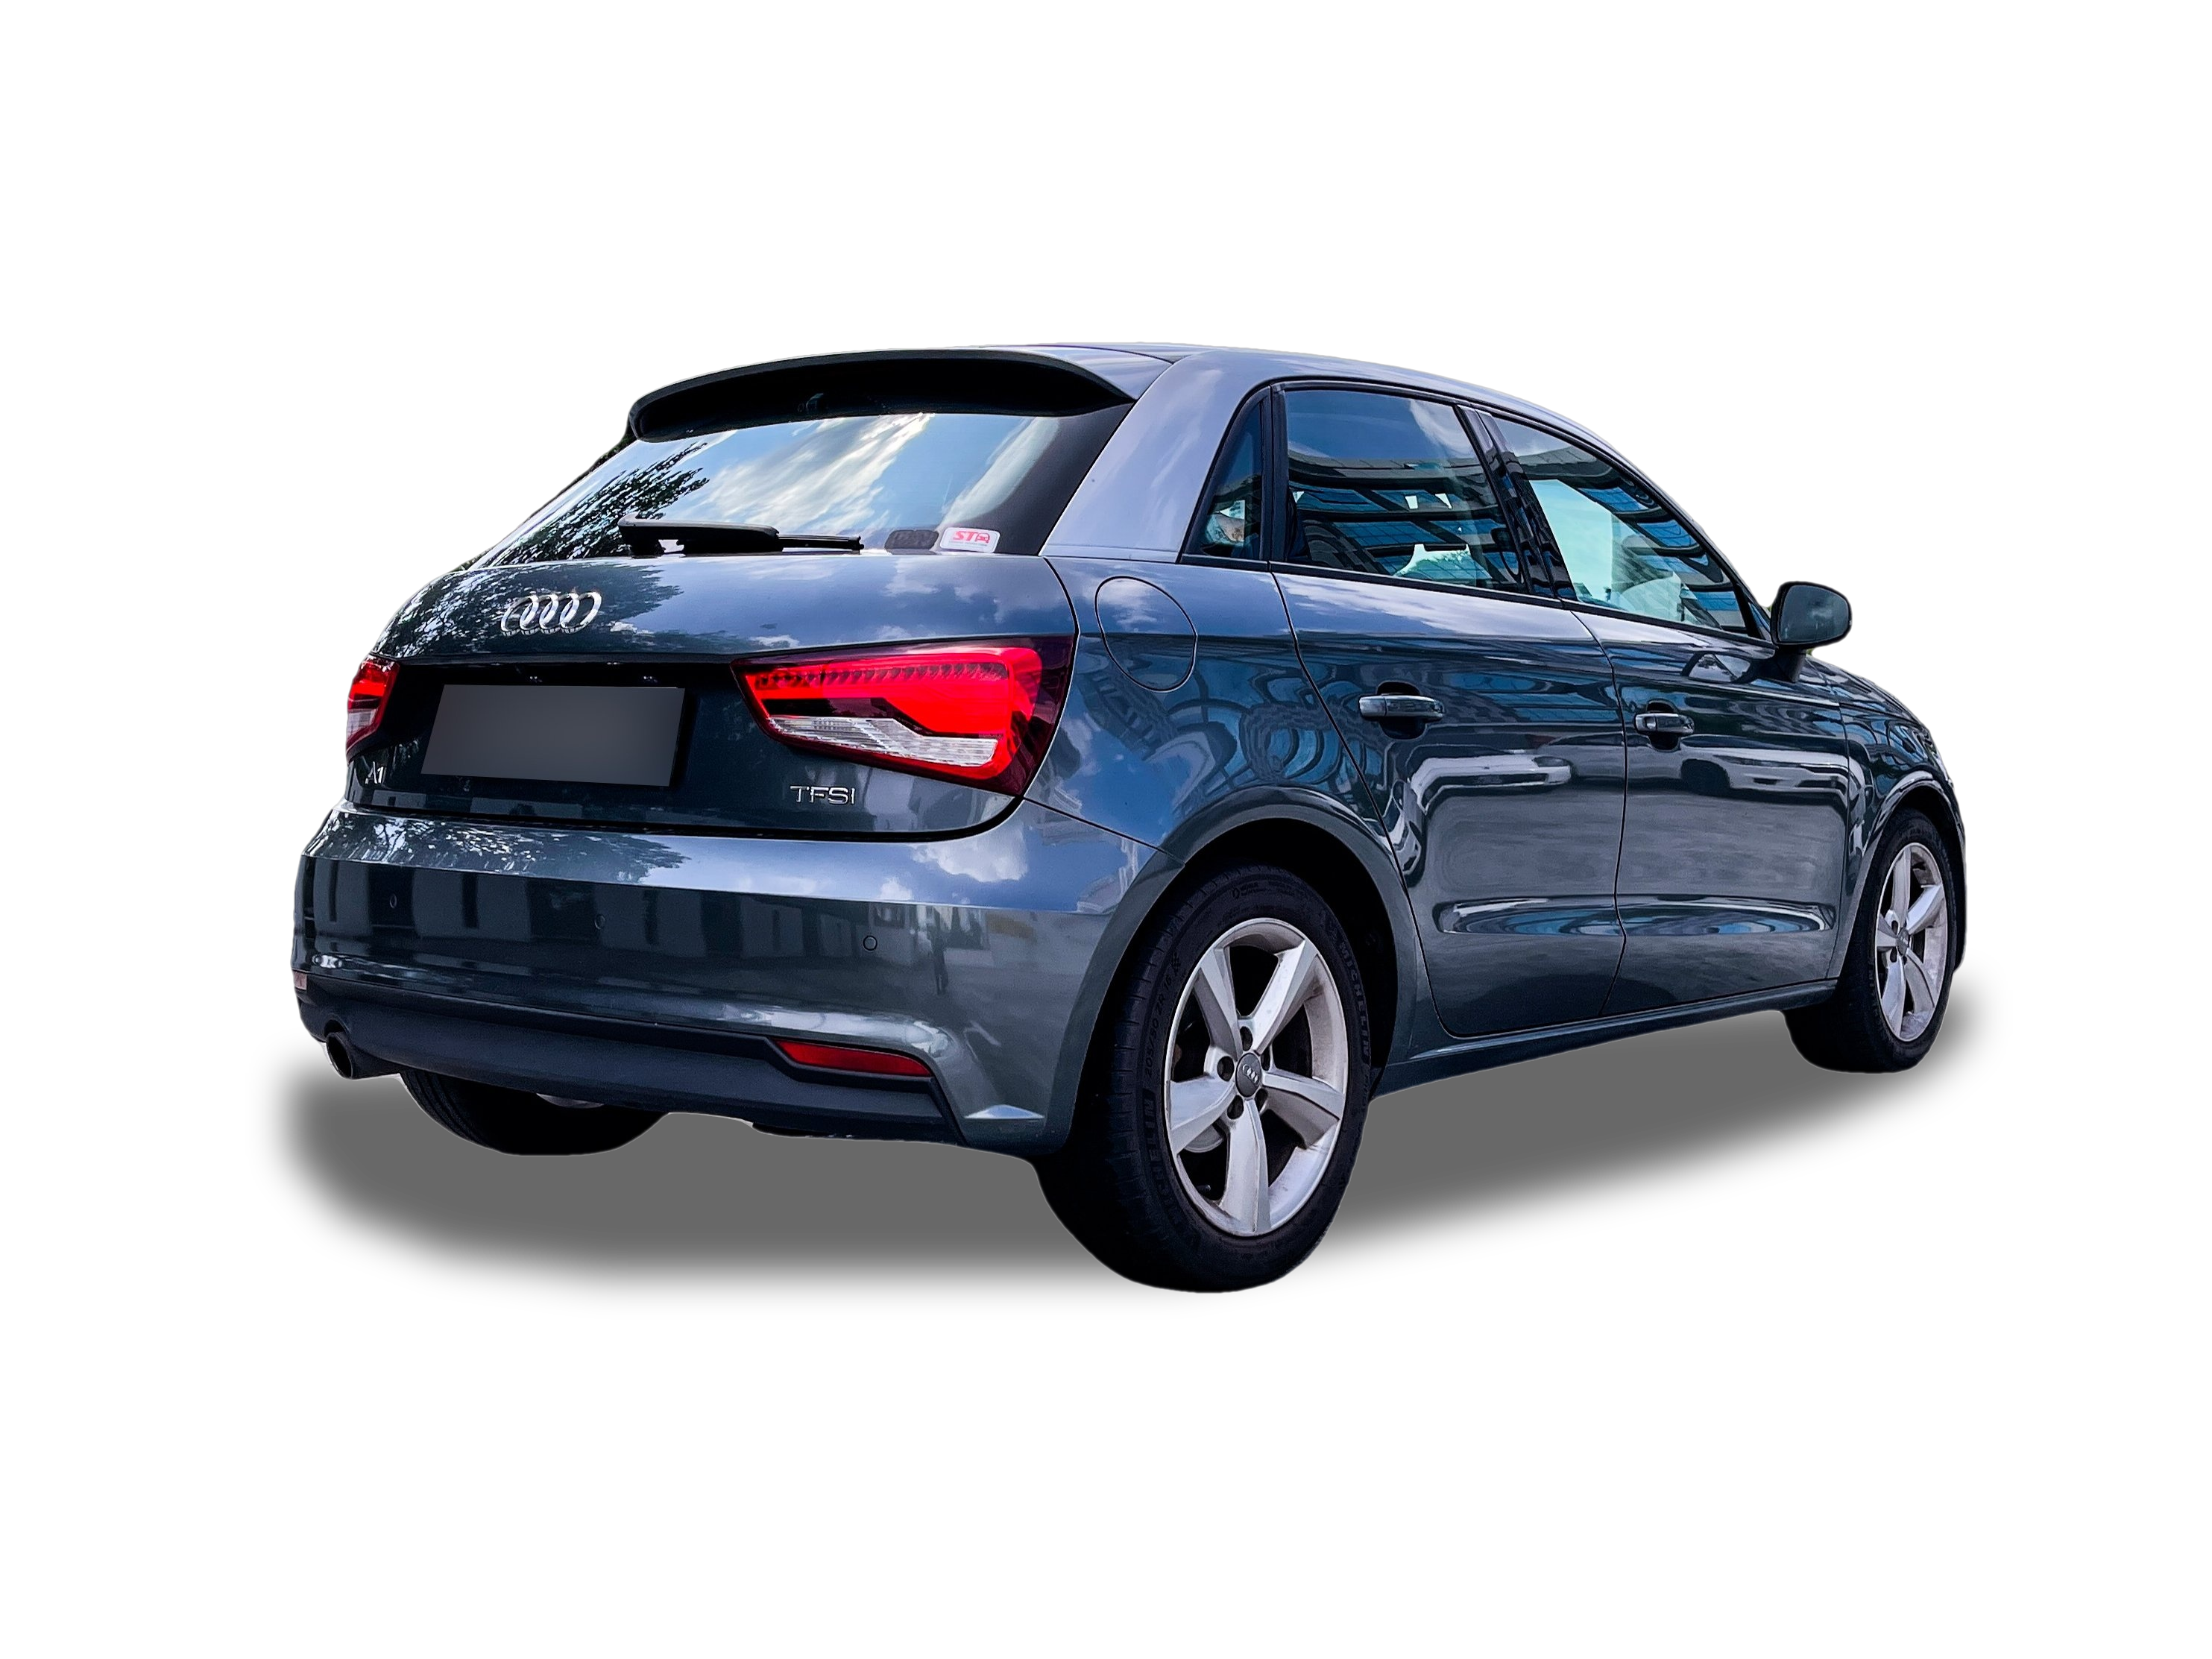

In [62]:
im_mask

914.8937875751503 962


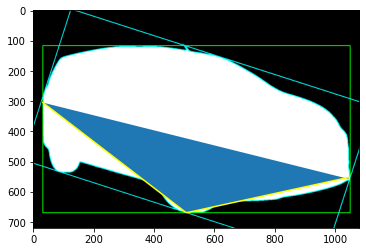

In [185]:
def find_intersect(l_m, r_m, t_m, b_m, mbottomleft, mtopleft, mtopright, mbottomright, bottom_horizontal, right_vertical, left_vertical):
    
    # front left
    bottom_slope =  (mbottomright[1]-mbottomleft[1])/(mbottomright[0]-mbottomleft[0])
    bottom_slope_c = mbottomright[1]-(bottom_slope*mbottomright[0])
    right_yintersect = bottom_slope*right_vertical+bottom_slope_c
    
    left_slope = (mtopleft[1]-mbottomleft[1])/(mtopleft[0]-mbottomleft[0])
    left_slope_c = mbottomleft[1]-(left_slope*mbottomleft[0])
    left_xinterset = (bottom_horizontal-left_slope_c) /left_slope
    
    front_left_polygon = [l_m, [int(left_xinterset),bottom_horizontal], b_m, [right_vertical,int(right_yintersect)],r_m]
    
    # front right
    left_xintersect = (left_vertical-bottom_slope_c)/bottom_slope
    print(left_xintersect, left_vertical)
    return front_left_polygon

front_left_polygon = find_intersect(l_m, r_m, t_m, b_m, mbottomleft, mtopleft, mtopright, mbottomright, bottomright[1], bottomright[0] , mbottomleft[0])

obj = Object(front_left_polygon)
Smoothed_obj = obj.Smooth_by_Chaikin(number_of_refinements = 0)
x1 = [i for i,j in Smoothed_obj]
y1 = [j for i,j in Smoothed_obj]
myline = lines.Line2D(x1,y1,color='yellow')
plt.gca().add_artist(myline)
poly_pts = Polygon(front_left_polygon)
smooth = Polygon(zip(x1,y1))
x, y = smooth.exterior.xy
plt.fill(x, y)

plt.imshow(img)


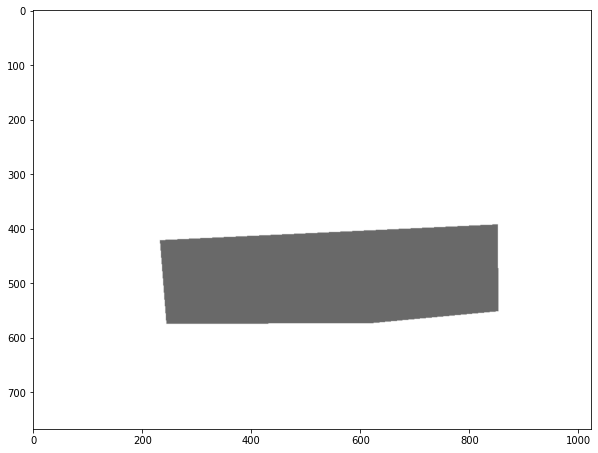

In [154]:
#half opacity#half opacity
from PIL import Image
from PIL import ImageDraw
foreground_pil = Image.open('/home/ubuntu/Users/maixueqiao/image-processing/{}_foreground.png'.format(img_path.split('_')[0])).convert('RGBA')

poly_ = Image.new('RGBA', foreground_pil.size)
pdraw = ImageDraw.Draw(poly_)
pdraw.polygon([(x1,y1) for x1,y1 in zip(x1,y1)],
              fill=(0,0,0,150),outline=(0,0,0,25))
plt.figure(figsize=(10,10))
plt.imshow(poly_)
plt.show()
poly_.save('poly_mask.png')

In [155]:
# import matplotlib.pyplot as plt
# from shapely.geometry import Polygon

# xs = [ 208, 1618 ]
# ys = [824, 590]

# # read the input image
# plt.imshow(img)
# plt.scatter(xcor, ycor, c = 'b', s = 50)
# plt.scatter(box[:, 0], box[:, 1], marker="x", color="red", s=200)
# plt.scatter(list(bboxx), list(bboxy), marker="x", color="red", s=200)
# plt.scatter(box[:, 0], box[:, 1], marker="x", color="yellow")
# plt.scatter(xs, ys, marker="o", color="orange")

# poly = [l_m, (bboxx[1], b_m[1]),b_m, (box[:, 0][2],box[:, 1][2]), r_m, l_m]
# obj = Object(poly)    
# Smoothed_obj = obj.Smooth_by_Chaikin(number_of_refinements = 2)
# x1 = [i for i,j in Smoothed_obj]
# y1 = [j for i,j in Smoothed_obj]
# myline = lines.Line2D(x1,y1,color='white')
# plt.gca().add_artist(myline)

# for i, j in zip(box[:, 0], box[:, 1]):
#     plt.text(i, j+-0.5, '({}, {})'.format(i, j), color="red")
    
# for i, j in zip(xcor, ycor):
#     plt.text(i, j+-0.5, '({}, {})'.format(i, j), color="b")

# poly_pts = Polygon(poly)
# x, y = poly_pts.exterior.xy
# plt.fill(x, y)

# plt.show()

In [158]:
mask_pil = Image.open('/home/ubuntu/Users/maixueqiao/image-processing/poly_mask.png').convert('RGBA')


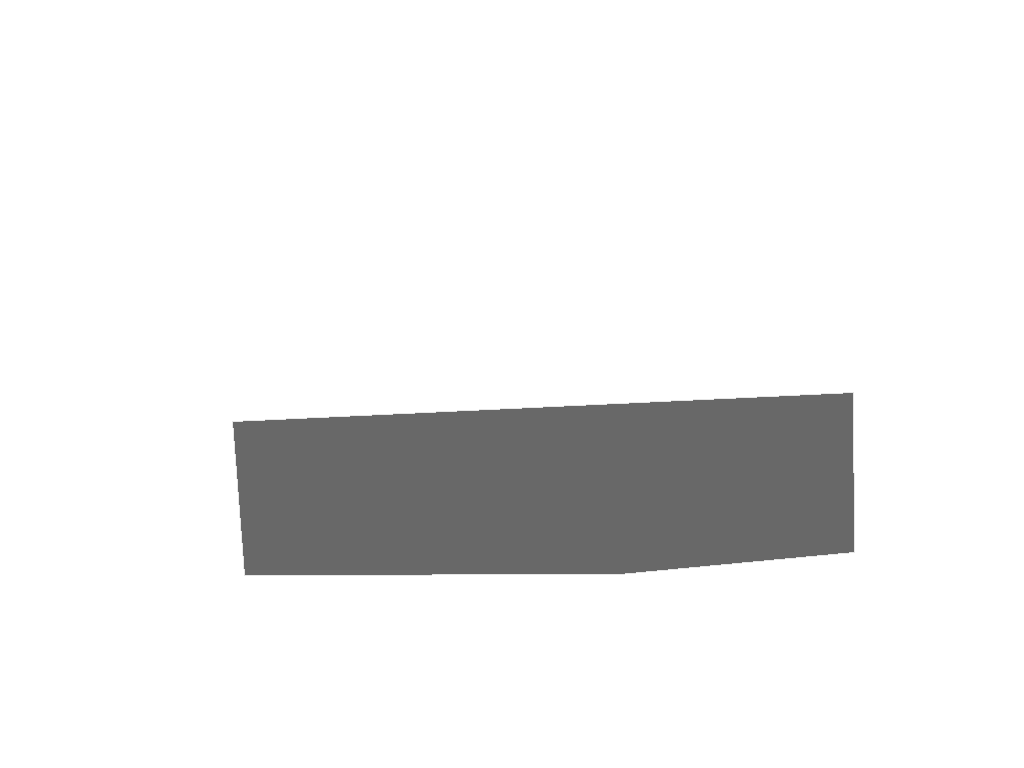

In [159]:
mask_pil


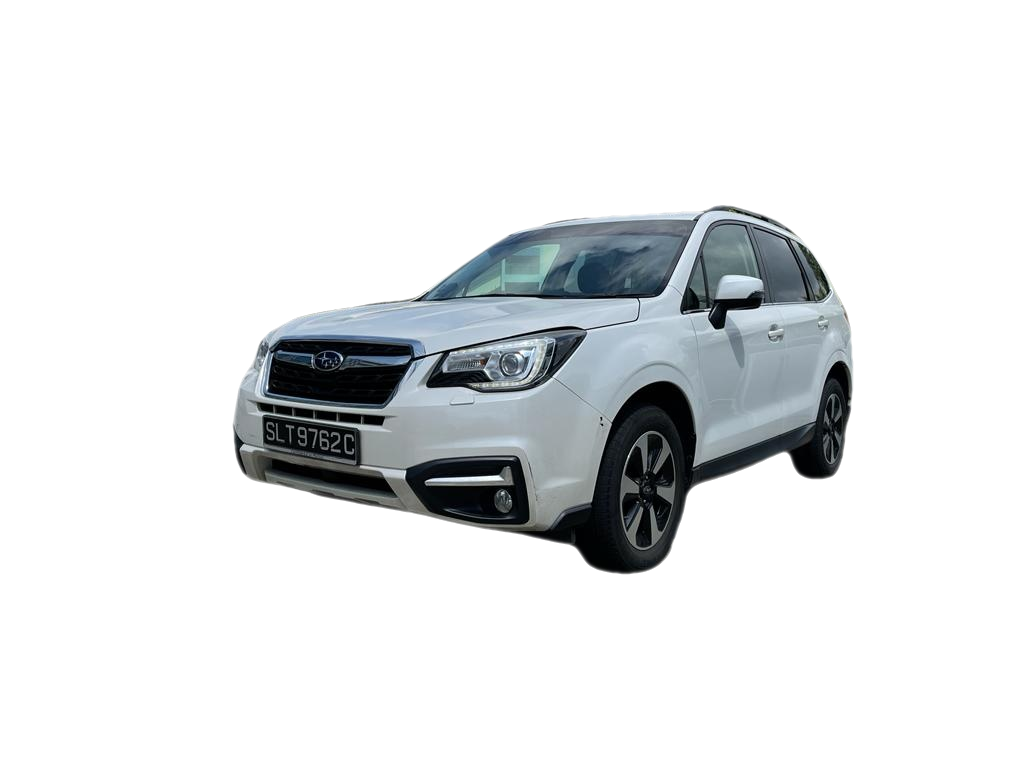

In [160]:
foreground_pil

In [163]:
from PIL import ImageFilter

# poly.resize(foreground_pil.size)
im_mask = mask_pil.filter(ImageFilter.GaussianBlur(25))
im_mask.paste(foreground_pil, (0,10),foreground_pil.convert('RGBA'))


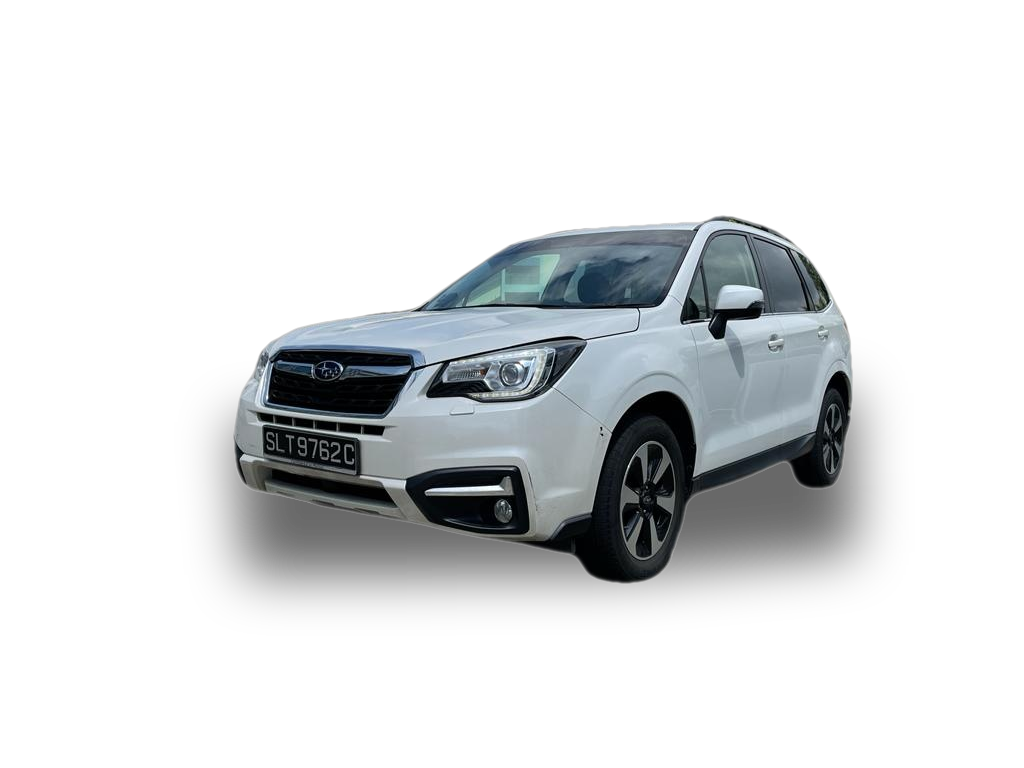

In [164]:
im_mask